# NetSat: Network Saturation Adversarial Attack

The following example presents the components that can be used to generate adversarial samples used in the experiments for the purpose of our paper: **"NetSat: Network Saturation Adversarial Attack"**.

Our components are used to perturb a dataset in the small example below.

Our functions allow to generate samples with NetSat, SignedNetSat samples, as well as with some traditional methods (FGSM and Normalized gradient). Our code allows to use the non-iterative and iterative versions of all of these attacks.

Import of all the necessary libraries first:

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# model and its preprocessing function
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input 

# reading images
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# imagenet utils
from tensorflow.keras.applications.imagenet_utils import decode_predictions

#reading images
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import to_categorical

# loss
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import glob, os

# for measuring similarity of weights
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
from tensorflow import keras

First, we read an example model (Xception) from Keras Applications. For NetSat, we generate perturbations with a modified model (cropped - we take the top layers and leave only the convolutional feature extractor) - inter_output_model (it gives the output from the intermediate layer of the original model - from the last conv layer to be precise (-3 for Xception - to choose a proper layer, one can find it e.g. via model.summary() function).

In [2]:
# reading a model:
model = tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
last_layer_index = -3
inter_output_model = tf.keras.Model(model.input, model.layers[last_layer_index].output )

First, we provide a function that can be used to generate adversarial perturbations (based on gradients of the given neural network). A proper attack name has to be chosen as the 'kind' parameter.

In [3]:
def generate_adversarial_perturbation(input_image, true_label, loss_function, nn_model, perturbation_min, 
                                      perturbation_max, kind='FGSM'):
    if kind == 'NetSat' or kind =='SignedNetSat':
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            prediction = nn_model(input_image)
            shape = tf.shape(prediction)
            desired_activation_values = tf.ones(shape) * np.max(prediction)
            loss = loss_function(desired_activation_values, prediction)
        gradient = tape.gradient(loss, input_image)
    else:
        with tf.GradientTape() as tape:
            tape.watch(input_image)    
            prediction = nn_model(input_image)
            loss = loss_function(true_label, prediction)
        gradient = tape.gradient(loss, input_image)

    if kind == 'FGSM' or kind =='SignedNetSat':
        gradient = tf.sign(gradient)
    elif kind == 'Norm' or kind == 'NetSat':
        # normalize to range -1 1
        gradient = (gradient - np.min(gradient)) / (np.max(gradient) - np.min(gradient))
        gradient = gradient * (perturbation_max - perturbation_min) + perturbation_min
    else:
        print('Wrong kind of adversarial attacks used. \'FGSM\' used instead')
        gradient = tf.sign(gradient)
    return gradient

Next, we can generate the adversarial sample based on the gradients (minimization or maximization can be used - for NetSat, we use minimize=True, and e.g. for FGSM, minimize=False).

In [4]:
def generate_adversarial_sample(input_image, true_label, loss_function, nn_model, epsilon, 
                                min_scale, max_scale, perturbation_min, perturbation_max, 
                                kind='FGSM', minimize=False):
    perturbation = generate_adversarial_perturbation(input_image, true_label, loss_function, nn_model, perturbation_min, perturbation_max, kind)
    # creating an adversarial sample
    if minimize:
        adversarial_sample = input_image - epsilon * perturbation
    else:
        adversarial_sample = input_image + epsilon * perturbation
    # normalize to range -1 1
    adversarial_sample = (adversarial_sample - np.min(adversarial_sample)) / (np.max(adversarial_sample) - np.min(adversarial_sample))
    adversarial_sample = adversarial_sample * (max_scale - min_scale) + min_scale
    return adversarial_sample, perturbation

The following function allows to generate an iterative variant of the considered attacks. We do not use momentum in our experiments for the purpose of the paper, however it has been implemented. 

In [5]:
def iterative_adversarial_sample(input_image, true_label, loss_function, nn_model, epsilon, min_scale, 
                                 max_scale, perturbation_min, perturbation_max, kind='FGSM', iterations=None,
                                 momentum=False, momentum_coefficient=None, minimize=False):
    adversarial_sample, perturbation = generate_adversarial_sample(input_image, true_label, 
                                                                   loss_function, nn_model, epsilon, min_scale, 
                                                                   max_scale, perturbation_min, perturbation_max, kind, minimize)
    old_perturbation = epsilon*perturbation
    for i in range(1, iterations):
        adversarial_sample, perturbation = generate_adversarial_sample(adversarial_sample, true_label, 
                                                                       loss_function, nn_model, epsilon, min_scale, 
                                                                       max_scale, perturbation_min, perturbation_max, kind, minimize)
        if momentum:
            if minimize:
                adversarial_sample = adversarial_sample - momentum_coefficient * old_perturbation
            else:
                adversarial_sample = adversarial_sample + momentum_coefficient * old_perturbation
            old_perturbation = epsilon * perturbation + momentum_coefficient * old_perturbation
    adversarial_sample = (adversarial_sample - np.min(adversarial_sample)) / (np.max(adversarial_sample) - np.min(adversarial_sample))
    adversarial_sample = adversarial_sample * (max_scale - min_scale) + min_scale
    return adversarial_sample

In [6]:
def generate_adversarial_image(input_image, true_label, loss_function, nn_model, epsilon, min_scale, 
                               max_scale, perturbation_min, perturbation_max, kind='FGSM', iterative=False, iterations=None,
                               momentum=False, momentum_coefficient=None, minimize=False):
    """Function returns an adversarial sample for the given model (nn_model), 
    image in a form of a tensor (in a batch form), loss function and additional attack parameters.
    If kind == NetSat or SignedNetSat, samples generated with our method are obtained (in this case,
    it is important to use a proper model as nn_model - it should be a model with top layers cropped).
    
    Parameters
    ----------
    input_image - an image to be perturbed
    true_label - a true label of the image (for 'NetSat' and 'SignedNetSat' as kind can be None) - necessary for FGSM and 
    loss_function - a loss function used to generate an adversarial sample, 
                    from tensorflow.keras.losses (CategoricalCrossentropy for FGSM/Norm, 
                    MeanSquaredError for NetSat/SignedNetSat)
    nn_model - a model used to generate adversarial samples (a cnn classifier for FGSM/Norm
                a cropped model - last layer is the last conv layer of the feature extractor - for NetSat/SignedNetSat)
    epsilon - perturbation degree coefficient
    min_scale - image minimum
    max_scale - image maximum
    perturbation_min - perturbation minimum (we use -1 to obtain the same min as in the signed variants of the attacks)
    perturbation_max - perturbation maximum (we use 1 to obtain the same max as in the signed variants of the attacks)
    kind (default: 'FGSM') - use 'NetSat', 'SignedNetSat' to generate samples with our attack and 'Norm' 
                            for the gradient values. We use 'FGSM' as default as it uses an original model (not cropped)
    iterative (default: False) - for the iterative version of the algorithms (if iterative=True but iterations=1 it is a 
                                    non-iterative variant as well)
    iterations (default: None) - number of iterations for the iterative variant - use only with iterative=True
    momentum (default: False) - flag for using momentum, if True, specify the momentum coeafficient
    momentum_coefficient (default: None) - momentu coefficient
    minimize (default: False) - whether to minimize or not (True for NetSat and SignedNetSat - or FGSM with 
                    e.g. least likely class, but we do not use it this way in our experiments - False for FGSM/Norm)
    
    Returns
    -------
    adversarial_sample[0] - an adversarial sample
    """
    if not iterative:
        adversarial_sample = generate_adversarial_sample(input_image, true_label, loss_function, 
                                                         nn_model, epsilon, min_scale, max_scale, perturbation_min, perturbation_max, kind, 
                                                                       minimize)
    else:
        adversarial_sample = iterative_adversarial_sample(input_image, true_label, loss_function, 
                                                                        nn_model, epsilon, min_scale, max_scale, perturbation_min, perturbation_max, kind, 
                                                                        iterations, momentum, momentum_coefficient, minimize)

    return adversarial_sample[0]

Below, we present the functions that can be used to read and perturb images and whole datasets. Our function for dataset reading is compatible with the format presented in **NIPS 2017 Adversarial Attacks and Defenses Competition** (https://github.com/cleverhans-lab/cleverhans/tree/master/cleverhans_v3.1.0/examples/nips17_adversarial_competition). The only difference is that our images are in the jpg format and theirs in png (this can be easily changed in the code). We use our TINY dataset for presentation in this notebook, but **the results in our paper have been obtained for the NIPS17 dataset (DEV)**. 

In [7]:
def read_and_perturb(filename, size, loss_function, nn_model, preprocess_function, epsilon, 
                     min_scale, max_scale, perturbation_min, perturbation_max,
                     kind='FGSM', iterative=False, iterations=None, true_label=None,
                     momentum=False, momentum_coefficient=None, minimize=True):
    img = load_img(filename, target_size=size)
    img_array = img_to_array(img)
    img_array_original = preprocess_function(img_array)
    img_array_original_for_pred = tf.convert_to_tensor(np.expand_dims(img_array_original, axis=0))
    img_array_adversarial = generate_adversarial_image(img_array_original_for_pred, 
                                                                     true_label, loss_function, nn_model, epsilon, 
                                                                     min_scale, max_scale, perturbation_min, 
                                                                     perturbation_max, kind, iterative,
                                                                     iterations, momentum, momentum_coefficient, 
                                                                     minimize)
    return img_array_original, img_array_adversarial

def create_dataset(main_folder_path, label_file_name, size, nn_model, loss_function, preprocess_function, epsilon, min_scale, 
                   max_scale, perturbation_min, perturbation_max, kind='FGSM', iterative=False, iterations=None, 
                   momentum=False, momentum_coefficient=None, minimize=True, num_of_labels=1000):
    
    X_adversarial = []
    X_original = []
    y = []
    
    labels_dataframe = pd.read_csv(label_file_name)
    
    os.chdir(".")
    # if one wants to use different file extension it can be simply changed here 
    # (e.g. png can be used instead of jpg)
    for file in glob.glob(main_folder_path + "/*.jpg"):
        img_label = file.split('\\')[1].split('.')[0]
        label = labels_dataframe.loc[labels_dataframe.ImageId == img_label].TrueLabel - 1
        label_one_hot = to_categorical(label, num_classes=num_of_labels)
        
        img_array_original, img_array_adversarial = read_and_perturb(filename=file, size=size, 
                                                                     loss_function=loss_function, nn_model=nn_model, 
                                                                     preprocess_function=preprocess_function, 
                                                                     epsilon=epsilon, min_scale=min_scale, max_scale=max_scale, 
                                                                     perturbation_min=perturbation_min, 
                                                                     perturbation_max=perturbation_max,
                                                                     kind=kind, iterative=iterative, iterations=iterations, 
                                                                     true_label=label_one_hot, 
                                                                     momentum=momentum, 
                                                                     momentum_coefficient=momentum_coefficient, 
                                                                     minimize=minimize)

        X_adversarial.append(img_array_adversarial)
        y.append(label)
        X_original.append(img_array_original)
    X_adversarial = np.asarray(X_adversarial)
    y = np.asarray(y)
    X_original = np.asarray(X_original)
    return X_original, X_adversarial, y


Read and perturb a dataset:

In [8]:
X_original, X_adversarial, y = create_dataset(main_folder_path='TINY_dataset', 
                                              label_file_name='TINY_dataset.csv', 
                                              size=(299,299), 
                                              nn_model=inter_output_model, 
                                              loss_function=MeanSquaredError(), 
                                              preprocess_function=preprocess_input, 
                                              epsilon=0.1, 
                                              min_scale=-1, 
                                              max_scale=1, 
                                              perturbation_min=-1, 
                                              perturbation_max=1, 
                                              kind='NetSat', 
                                              iterative=True, 
                                              iterations=2, 
                                              momentum=False, 
                                              momentum_coefficient=None, 
                                              minimize=True,
                                              num_of_labels=1000)

Now, we've got a dataset with 2 RGB samples:

In [9]:
X_adversarial.shape

(2, 299, 299, 3)

In [10]:
y.shape

(2, 1)

Let's see the true label of the first element of our dataset:

In [11]:
decode_predictions(to_categorical(y[0], num_classes=1000), top=1)

[[('n02504013', 'Indian_elephant', 1.0)]]

Presenting the image (+ scaling) at index 0 of the dataset with predictions:

Original image at index 0:


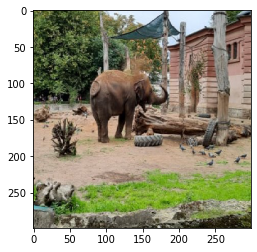

1/1 [==============================] - 1s 954ms/step
[[('n02504013', 'Indian_elephant', 0.37895826), ('n02504458', 'African_elephant', 0.30291805), ('n01871265', 'tusker', 0.07901739), ('n02410509', 'bison', 0.013021033), ('n02480855', 'gorilla', 0.003293046)]]
Adversarial image at index 0:


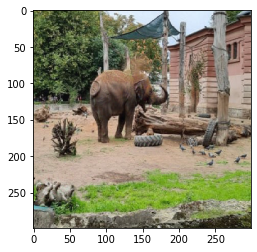

1/1 [==============================] - 0s 140ms/step
[[('n03538406', 'horse_cart', 0.03405411), ('n02403003', 'ox', 0.029804349), ('n02108551', 'Tibetan_mastiff', 0.025156414), ('n02109525', 'Saint_Bernard', 0.023915064), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.022691647)]]


In [12]:
original_sample = X_original[0]
scaled_for_presentation = (original_sample - np.min(original_sample)) / (np.max(original_sample) - np.min(original_sample))
print('Original image at index 0:')
plt.imshow(scaled_for_presentation)
plt.show()
print(decode_predictions(model.predict(np.expand_dims(original_sample, axis=0))))

adversarial_sample = X_adversarial[0]
scaled_for_presentation = (adversarial_sample - np.min(adversarial_sample)) / (np.max(adversarial_sample) - np.min(adversarial_sample))
print('Adversarial image at index 0:')
plt.imshow(scaled_for_presentation)
plt.show()
print(decode_predictions(model.predict(np.expand_dims(adversarial_sample, axis=0))))

The following functions can be used to (1) determine a Sorted Class Similarity Matrix (SCSM) for a particular CNN classifier based on the weights of the final layer and (2) compute the value of our Dissimilarity Metric for an example or a dataset (with labels given in a numerical form and NOT in a one-hot encoding.

In [13]:
def create_SCSM(model):
    """ Function returns a NumPy array with Sorted Class Similarity Matrix
    Each row of this table stores a 'class similarity landscape' for a 
    particular class. The first element is always this particular 
    class (cosine similarity equals 1 for the same element). 
    Then, the most similar classes are sorted in a descending order
    (from the most to the least similar ones)
    
    Parameters
    ----------
    model - keras trained  model
    
    Returns
    -------
    Sorted Class Similarity Matrix (SCSM) - NumPy array
    """
    #necessary imports:
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity
    classes_i = np.moveaxis(model.layers[-1].get_weights()[0], 0, -1)
    classes_j = np.moveaxis(model.layers[-1].get_weights()[0], 0, -1)
    CSM = cosine_similarity(classes_i, classes_j)
    # sort in a descending order and return indexes of classes
    SCSM = np.argsort(-CSM, axis=1)
    return SCSM

def Dissimilarity_Metric(y_true, y_pred, num_of_classes):
    SCSM = create_SCSM(model)
    y_reshaped = np.reshape(y_true, (y_true.shape[0]))
    DM = (SCSM[y_reshaped] == np.expand_dims(y_pred, axis=1))
    DM = np.argmax(DM.astype(int), axis=1)
    DM = np.mean(DM / num_of_classes)
    return DM

First, we compute the DM for a clear dataset. We obtain 0, as the model returned correct labels.

In [14]:
y_pred = np.argmax(model.predict(X_original), axis=1)
y_true = y # golden retriever - ground truth label
Dissimilarity_Metric(y_true, y_pred, num_of_classes=1000)

1/1 [==============================] - 0s 216ms/step


0.0

Now, we can compute the DM value for a perturbed dataset. DM value is larger than in the previous case (bigger value represent a larger mean dissimilarity samples)

In [15]:
y_pred_adv = np.argmax(model.predict(X_adversarial), axis=1)
y_true = y # golden retriever - ground truth label
Dissimilarity_Metric(y_true, y_pred_adv, num_of_classes=1000)

1/1 [==============================] - 0s 221ms/step


0.0155